In [1]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [2]:
X_train = train.drop(columns=['averageRating', 'canHaveEpisodes'])
y_train = train['averageRating']

X_test = test.drop(columns=['averageRating', 'canHaveEpisodes'])
y_test = test['averageRating']

# One-hot encode titleType
X_train = pd.get_dummies(X_train, columns=['titleType'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['titleType'], drop_first=True)

In [3]:
X_train.columns

Index(['startYear', 'runtimeMinutes', 'numRegions', 'ratingCount',
       'companiesNumber', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'deltaCredits',
       'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
       'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort',
       'titleType_tvSpecial', 'titleType_video', 'titleType_videoGame'],
      dtype='object')

In [4]:
# Preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np


to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews',
       'deltaCredits'
]

# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))



scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Preprocess the target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K


max_val = y_train.max()
min_val = y_train.min()

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),  # Regression output
    layers.Lambda(lambda x: x * (max_val - min_val) + min_val),  # Scale output back to original range
])

model.compile(optimizer='adam', loss='mae',
              metrics=['mse'])

2025-09-24 11:40:56.669952: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
import numpy as np

# Ensure correct shapes
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1)
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1)

history = model.fit(
    X_train, y_train, epochs=500,
    batch_size=32, validation_split=0.2,
    # Early stopping
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=20,
            restore_best_weights=True
        )],
    verbose=1
)
model.evaluate(X_test, y_test)

Epoch 1/500


ValueError: No gradients provided for any variable.

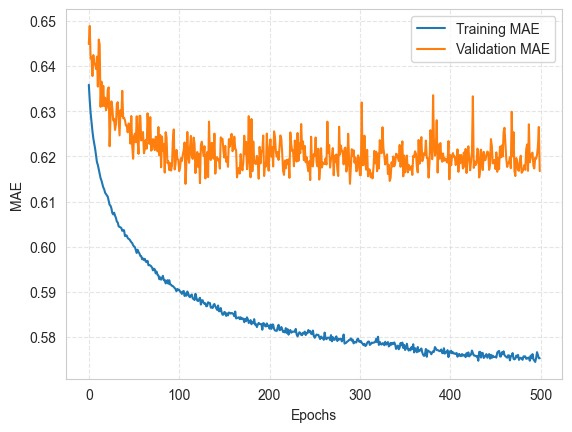

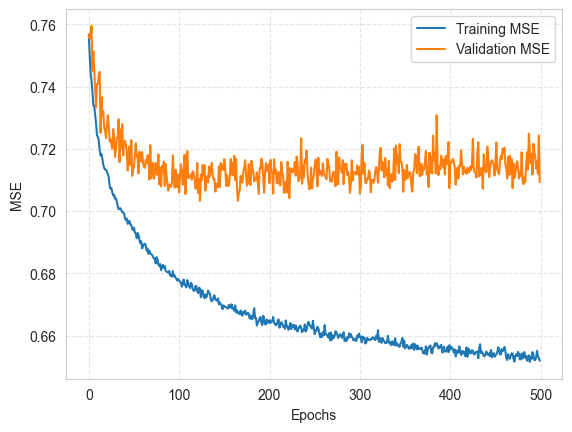

In [ ]:
# Plot history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training MAE')
plt.plot(history.history['val_loss'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

# Plot MAE
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

In [ ]:
# R-squared, MSE and MAE computation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step
MSE: 0.723414065456471
MAE: 0.6196090554833165
R-squared: 0.28458688439886937


In [ ]:
# Reverse scale predictions
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

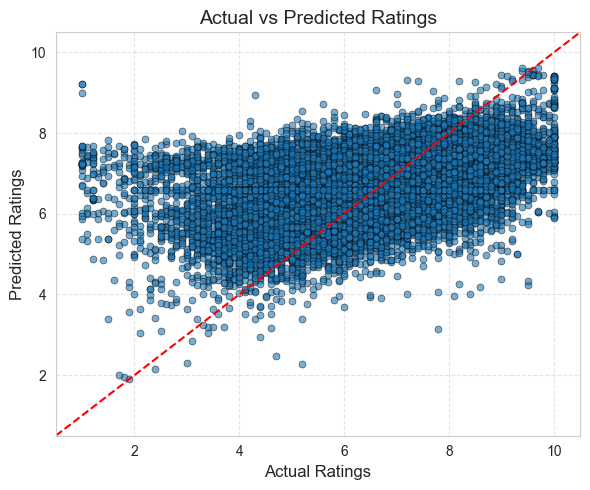

In [ ]:
import seaborn as sns

plt.figure(figsize=(6,5))  # larghezza 8, altezza 6
sns.set_style("whitegrid")

# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.6, s=25, edgecolor='k', linewidth=0.5)

# Diagonal line
lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
plt.plot(lims, lims, 'r--', linewidth=1.5)

plt.xlabel("Actual Ratings", fontsize=12)
plt.ylabel("Predicted Ratings", fontsize=12)
plt.title(f"Actual vs Predicted Ratings", fontsize=14)
plt.xlim(lims)
plt.ylim(lims)

# Grid 
plt.grid(alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()


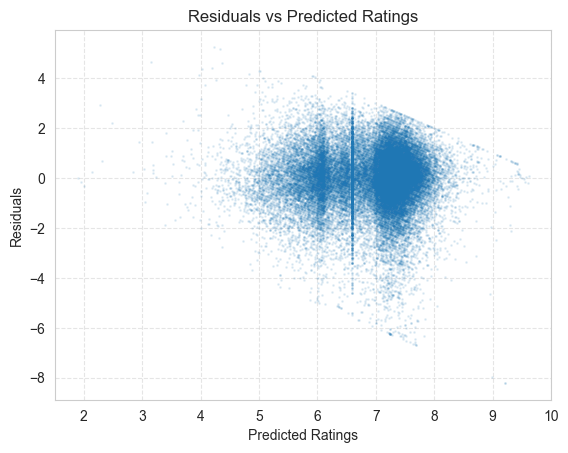

In [ ]:
# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.1, s=1, edgecolors=None)
# plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Ratings')
plt.grid(alpha=0.5, linestyle='--')
plt.show()